In [1]:
import os
import pandas as pd
import numpy as np
import pickle

In [2]:
from pgmpy.models.BayesianNetwork import BayesianNetwork
from pgmpy.estimators import StructureEstimator, BayesianEstimator, HillClimbSearch, PC
from sklearn.preprocessing import LabelEncoder

class BayesianModel(BayesianNetwork):

    def __init__(self, *, 
        ebunch=None,
        n_jobs = -1, 
        graph_search_algo=HillClimbSearch, 
        
        scoring_method='k2score', 
        start_dag=None, 
        fixed_edges=set(), 
        tabu_length=100, 
        max_indegree=None, 
        black_list=None, 
        white_list=None, 
        epsilon=0.0001, 
        max_iter=1000000.0, 
        show_progress=True, 

        variant='stable',
        ci_test='chi_square',
        max_cond_vars=5,
        return_type='dag',
        significance_level=0.01,

        estimator=BayesianEstimator, 
        prior_type='BDeu', 
        pseudo_counts=[], 
        equivalent_sample_size=5
        ):
        
        '''
        if graph_search_algo == PC and return_type in ['pdag', 'cpdag']:
            raise ValueError('BayesianModel currently has no support for PDAG\'s')
        '''

        super().__init__(ebunch)
        
        self.ebunch = ebunch
        self.n_jobs = n_jobs
        self.graph_search_algo = graph_search_algo
        self.scoring_method = scoring_method
        self.start_dag = start_dag
        self.fixed_edges = fixed_edges
        self.tabu_length = tabu_length
        self.max_indegree = max_indegree
        self.black_list = black_list
        self.white_list = white_list
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.show_progress = show_progress

        self.variant = variant
        self.ci_test = ci_test
        self.max_cond_vars = max_cond_vars
        self.return_type = return_type
        self.significance_level = significance_level

        self.estimator = estimator
        self.prior_type = prior_type
        self.pseudo_counts = pseudo_counts
        self.equivalent_sample_size = equivalent_sample_size

    def fit(self, X_train, y_train, **fit_params):

        data = pd.concat([X_train, y_train], axis=1)
        graph_search_est = self.graph_search_algo(data)
        if self.graph_search_algo == HillClimbSearch:
            parameters = dict(
                scoring_method=self.scoring_method,
                start_dag=self.start_dag,
                fixed_edges=self.fixed_edges,
                tabu_length=self.tabu_length,
                max_indegree=self.max_indegree,
                black_list=self.black_list,
                white_list=self.white_list,
                epsilon=self.epsilon,
                max_iter=self.max_iter,
                show_progress=self.show_progress
            )
        elif self.graph_search_algo == PC:
            parameters = dict(
                variant=self.variant,
                ci_test=self.ci_test,
                max_cond_vars=self.max_cond_vars,
                return_type=self.return_type,
                significance_level=self.significance_level,
                show_progress=self.show_progress
            )
        dag = graph_search_est.estimate(**parameters)

        

        extra_columns = list(set(data.columns) - set(dag.nodes))
        if y_train.name in extra_columns:
            raise ValueError('Resulting DAG does not contain target. It cannot be used to make predictions.')
        if len(extra_columns) > 0:
            data = data.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        
        self._dag = dag
        self.ebunch = list(dag.nodes)
        super().__init__(dag)
        print('Now fitting the graph...')
        super().fit(
            data, 
            estimator=self.estimator, 
            prior_type=self.prior_type, 
            pseudo_counts=self.pseudo_counts,
            equivalent_sample_size=self.equivalent_sample_size,
            n_jobs = self.n_jobs,
            **fit_params
        )
        print('Succesfully fitted the graph')

        self.X_ = X_train
        self.y_ = y_train
        self.fit_params_ = fit_params
        self.classes_ = LabelEncoder().fit(y_train).classes_

        return self

    def predict(self, X, stochastic=False, n_jobs=None):
        if n_jobs == None:
            n_jobs = self.n_jobs
        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        y_pred_df = super().predict(X, stochastic, n_jobs)
        y_pred = y_pred_df.to_numpy()
        self.y_pred_ = y_pred

        return y_pred

    def predict_proba(self, X):
        extra_columns = list(set(X.columns) - set(self.nodes))
        if len(extra_columns) > 0:
            X = X.drop(columns=extra_columns)
        elif len(extra_columns) < 0:
            raise ValueError('Invalid value for extra_columns')
        y_pred_proba_df = super().predict_probability(X)
        y_pred_proba = y_pred_proba_df.to_numpy()
        self.y_pred_proba_ = y_pred_proba
        
        return y_pred_proba
    
    def get_params(self, deep=True):
        return {
            'ebunch':self.ebunch,
            'graph_search_algo':self.graph_search_algo,
            'scoring_method':self.scoring_method,
            'start_dag':self.start_dag,
            'fixed_edges':self.fixed_edges,
            'tabu_length':self.tabu_length,
            'max_indegree':self.max_indegree,
            'black_list':self.black_list,
            'white_list':self.white_list,
            'epsilon':self.epsilon,
            'max_iter':self.max_iter,
            'show_progress':self.show_progress,
            'variant':self.variant,
            'ci_test':self.ci_test,
            'max_cond_vars':self.max_cond_vars,
            'return_type':self.return_type,
            'significance_level':self.significance_level,
            'estimator':self.estimator,
            'prior_type':self.prior_type,
            'pseudo_counts':self.pseudo_counts,
            'equivalent_sample_size':self.equivalent_sample_size,
            'n_jobs':self.n_jobs
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

def cv_scorer(ml_algo, scoring, *data, model_name=None, algo_params={}, resampler=None, output=True):    
    if len(data) == 2:
        X, y = tuple(data)
        w = None
    elif len(data) == 3:
        X, y, w = tuple(data)
    else:
        print('Invalid length for "data".')
        return
    
    if resampler != None:
        model = Pipeline([('Resampling', resampler()), (model_name, ml_algo(**algo_params))])
    else:
        model = Pipeline([(model_name, ml_algo(**algo_params))])
    
    cv_scores = cross_validate(model, X, y, scoring=scoring, fit_params={}, return_estimator=True)
    if output == True:
        if type(model_name) != type(None):
            print(model_name + ' cv_scores:')
        else:
            print('cv_scores:')
        print(cv_scores)
        print()
    
    cv_scores_summary = {}
    cv_scores_summary['estimator'] = cv_scores['estimator']
    for score in scoring:
        scores_ = cv_scores['test_' + score]
        mean_ = cv_scores['test_' + score].mean()
        std_ = cv_scores['test_' + score].std()
        
        cv_scores_summary[score]= dict(zip(['scores', 'mean', 'std'], [scores_, mean_, std_]))
        
        if output == True:
            print(score + ' mean: ' + f'{mean_:0.2f}')
            print(score + ' std: ' + f'{std_:0.4f}')
            print()
    if print == True:
        print()
    
    if type(model_name) != type(None):
        return {model_name:cv_scores_summary}, cv_scores
    else:
        return cv_scores_summary, cv_scores

In [4]:
def no_parents_black_list(list_orig, list_no_parents):
    '''Given a list of nodes, list_orig, and another list of nodes that should not have parents, 
    list_no_parents, generates the required black_list for use in graph search algorithms'''

    list_start = []
    list_end = []
    for node_no_parent in list_no_parents:
        list_temp_1 = list_orig.copy()
        list_temp_1.remove(node_no_parent)
        list_temp_2 = [node_no_parent] * len(list_temp_1)
        list_start.append(list_temp_1)
        list_end.append(list_temp_2)
    assert len(list_start) == len(list_end)
    
    black_list = []
    for i in range(len(list_start)):
        black_list = black_list + list(zip(list_start[i], list_end[i]))

    return black_list



In [5]:
from sklearn.metrics import roc_curve

def find_threshold(fpr_chosen, y_test, y_proba):
    fpr, _, thresholds= roc_curve(y_test, y_proba)
    indices = np.where(fpr <= fpr_chosen)[0]
    index = indices[-1:-2:-1][0] + 1
    return thresholds[index]

def predict_with_treshold(proba, threshold):
    return (proba >= threshold).astype(float)

In [6]:
def value_counts(df, dropna=True):
    for column in df.columns:
        print(df[column].value_counts(dropna=dropna), '\n')

In [7]:
def drop_low_counts(df, threshold, ignored_columns=[], verbose=False):
    
    #Initialize list of columns to ignore
    if isinstance(ignored_columns, str):
        ignored_columns = [ignored_columns]
    elif not isinstance(ignored_columns, list):
        raise TypeError('ignored_columns must be either str or list.')
    if verbose:
        if len(ignored_columns) == 0:
            print('No columns chosen to ignore')
        else:
            print('Columns to ignore:', *ignored_columns)
    n_rows = df.shape[0]

    #For each column not in ignored_columns, find values to drop
    to_drop = []
    for column in df.columns:
        if column not in ignored_columns:
            counts = df[column].value_counts(dropna=False)
            for value, count in counts.items():
                proportion = count / n_rows
                if proportion <= threshold:
                    to_drop.append((column, value))
    if len(to_drop) == 0:
        if verbose:
            print('No rows to drop')
        return df
    if verbose:
        print('Column-value pairs to drop:', *to_drop)

    #Find filter to use on the dataframe
    filter = np.array([False] * df.shape[0])
    for column, value in to_drop:
        filter = filter | (df[column] == value)
    drop_indices = df[filter].index
    df_new = df.drop(drop_indices).reset_index(drop=True)

    #Extra information to print out if verbose == True
    if verbose == True:
        n_rows_dropped = n_rows - df_new.shape[0]
        percent_dropped = round(n_rows_dropped / n_rows * 100, 2)
        print('Number of rows dropped:', n_rows_dropped)
        print('Percentage of rows dropped:', percent_dropped)

    return df_new

In [8]:
with open('dataframe_clean.pkl', 'rb') as f:
    df = pickle.load(f)

In [9]:
df.columns

Index(['Good_Health', 'Health_Insurance', 'Hypertension', 'High_Cholesterol',
       'Asthma_Status', 'Arthritis', 'Race', 'Age_Cat', 'BMI_Cat',
       'Education_Level', 'Income_Level', 'Smoker_Status', 'Heavy_Drinker',
       'Physical_Activity', 'Seatbelt', 'Flu_Shot', 'Pneumonia_Vaccine', 'HIV',
       'Bronchitis', 'Depression', 'Kidney_Disease', 'Diabetes', 'SEX',
       'Marital_Status', 'Sodium', 'Heart_Disease', 'Sample_Weights'],
      dtype='object')

In [10]:
included_columns = ['Good_Health', 'Hypertension', 'High_Cholesterol', 'Smoker_Status', 'Age_Cat', 'Diabetes', 'Sodium', 'Heavy_Drinker', 'Heart_Disease', 'SEX', 'Sample_Weights']
df = df[included_columns]
df

,Good_Health,Hypertension,High_Cholesterol,Smoker_Status,Age_Cat,Diabetes,Sodium,Heavy_Drinker,Heart_Disease,SEX,Sample_Weights
0,2.0,1.0,1.0,3.0,5.0,2.0,999.0,2.0,0.0,2.0,341.384853
1,1.0,2.0,2.0,1.0,4.0,2.0,2.0,2.0,0.0,2.0,108.060903
3,2.0,1.0,1.0,4.0,5.0,2.0,2.0,2.0,0.0,2.0,341.384853
4,2.0,2.0,2.0,4.0,5.0,2.0,2.0,2.0,0.0,2.0,258.682223
5,1.0,1.0,2.0,4.0,6.0,2.0,2.0,2.0,0.0,2.0,256.518591
...,...,...,...,...,...,...,...,...,...,...,...
441451,2.0,1.0,1.0,4.0,6.0,1.0,1.0,2.0,0.0,2.0,531.980410
441452,1.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,0.0,2.0,746.416599
441453,2.0,1.0,1.0,3.0,6.0,2.0,999.0,2.0,0.0,2.0,207.663634
441454,1.0,1.0,2.0,4.0,4.0,2.0,1.0,2.0,0.0,1.0,515.758894


In [11]:
df['Heart_Disease'] = df['Heart_Disease'].cat.remove_unused_categories()
df = df.astype(int).astype(str)

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Heart_Disease', 'Sample_Weights'])
y = df['Heart_Disease']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [13]:
black_list = no_parents_black_list(list(pd.concat([X, y], axis=1).columns), ['SEX', 'Age_Cat'])
black_list

[('Good_Health', 'SEX'),
 ('Hypertension', 'SEX'),
 ('High_Cholesterol', 'SEX'),
 ('Smoker_Status', 'SEX'),
 ('Age_Cat', 'SEX'),
 ('Diabetes', 'SEX'),
 ('Sodium', 'SEX'),
 ('Heavy_Drinker', 'SEX'),
 ('Heart_Disease', 'SEX'),
 ('Good_Health', 'Age_Cat'),
 ('Hypertension', 'Age_Cat'),
 ('High_Cholesterol', 'Age_Cat'),
 ('Smoker_Status', 'Age_Cat'),
 ('Diabetes', 'Age_Cat'),
 ('Sodium', 'Age_Cat'),
 ('Heavy_Drinker', 'Age_Cat'),
 ('SEX', 'Age_Cat'),
 ('Heart_Disease', 'Age_Cat')]

In [22]:
path = './cpdag.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        cpdag = pickle.load(f)
        print('Loaded cpdag')
else:
    pc_algo = PC(pd.concat([X_train, y_train], axis=1))
    cpdag = pc_algo.estimate(return_type='cpdag')
    print('cpdag built')

Loaded cpdag


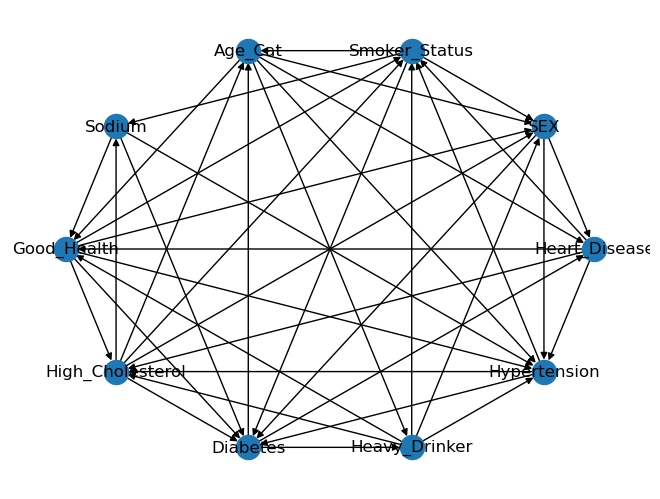

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw_shell(cpdag, with_labels=True)
plt.show()

In [24]:
path = './bm_predictions.pkl'
if os.path.exists(path):
    with open(path, 'rb') as f:
        _ = pickle.load(f)
        bm = pickle.load(f)
        y_test = pickle.load(f)
        y_pred = pickle.load(f)
        y_proba = pickle.load(f)
        print(f'Loaded from {path}.')
else:
    from pgmpy.estimators import BayesianEstimator

    bm = BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5, black_list=black_list)
    bm.fit(X_train, y_train)
    y_pred = bm.predict(X_test)
    y_proba = bm.predict_proba(X_test)
    with open(path, 'wb') as f:
        pickle.dump(4, f)
        pickle.dump(bm, f)
        pickle.dump(y_test, f)
        pickle.dump(y_pred, f)
        pickle.dump(y_proba, f)
    print('Model trained.')

Loaded from ./bm_predictions.pkl.


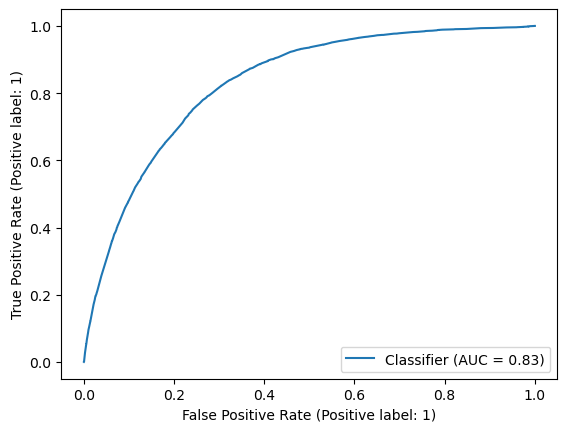

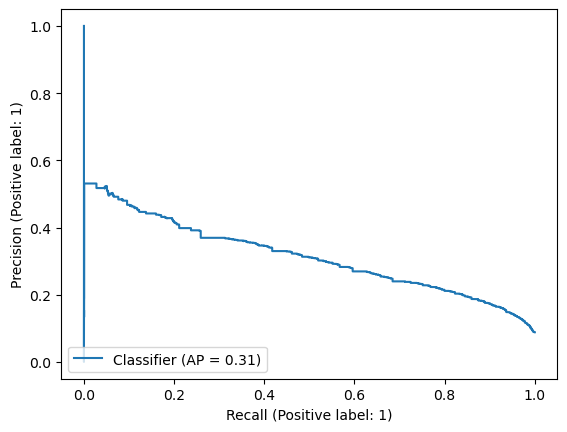

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(y_test, y_proba[:, 1], pos_label='1')
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_proba[:, 1], pos_label='1')
plt.show()

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     79776
           1       0.52      0.05      0.09      7727

    accuracy                           0.91     87503
   macro avg       0.72      0.52      0.52     87503
weighted avg       0.88      0.91      0.88     87503



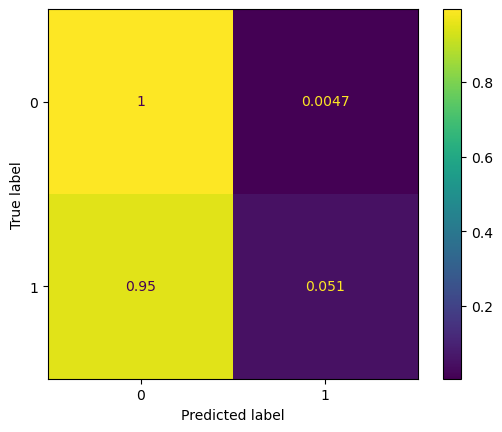

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
plt.show()

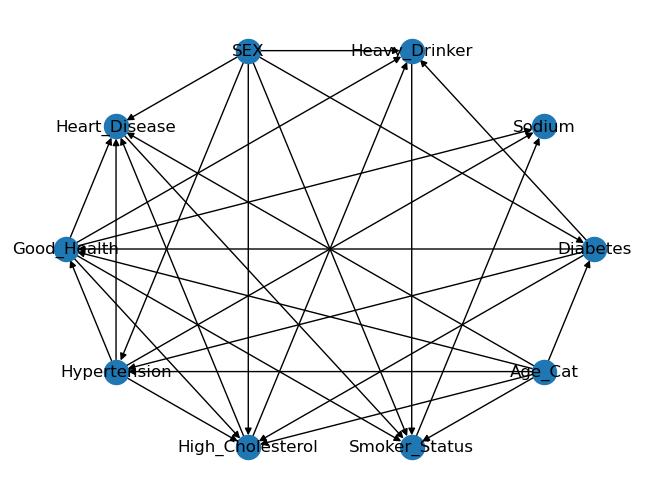

In [27]:
import networkx as nx

nx.draw_shell(bm, with_labels=True)

In [37]:
_, X_sample, _, y_sample = train_test_split(X, y, test_size=0.5, stratify=y)
X_sample = X_sample.reset_index(drop=True)
y_sample = y_sample.reset_index(drop=True)
temp_df = drop_low_counts(pd.concat([X_sample, y_sample], axis=1), 0.01, ignored_columns='Sample_Weight', verbose=True)
X_sample = temp_df.drop(columns='Heart_Disease')
y_sample = temp_df['Heart_Disease']
del(temp_df)
print('Number of columns in sampled dataframe:', X_sample.shape[0])

Columns to ignore: Sample_Weight
Column-value pairs to drop: ('Good_Health', '9') ('Hypertension', '9') ('High_Cholesterol', '9') ('Diabetes', '7') ('Diabetes', '9') ('Diabetes', '999') ('Sodium', '7') ('Sodium', '9')
Number of rows dropped: 3247
Percentage of rows dropped: 1.48
Number of columns in sampled dataframe: 215510


  0%|          | 0/10 [00:00<?, ?it/s]

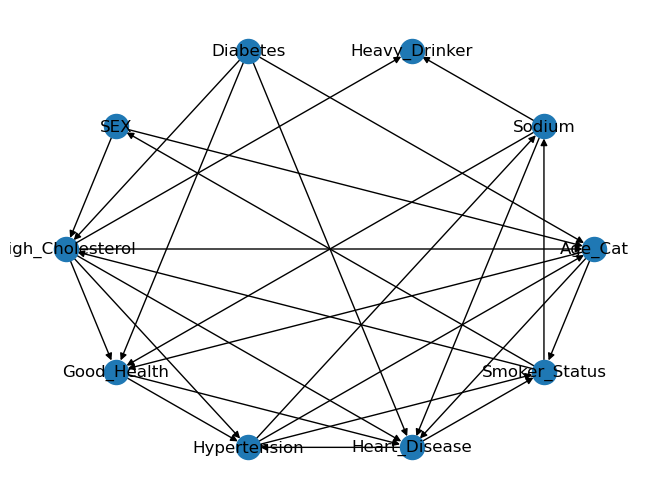

In [38]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

test_pc = PC(pd.concat([X_sample, y_sample], axis=1))
pdag = test_pc.estimate(variant='orig', max_cond_vars=10, return_type='pdag')

'''
try:
    cycle = None
    cycle = nx.find_cycle(dag)
except nx.exception.NetworkXNoCycle:
    print('No cycle found')
else:
    print('Cycle found')
    print(cycle)help(
'''

nx.draw_shell(pdag, with_labels=True)
plt.show()

with open('./pdag.pkl', 'wb') as f:
    pickle.dump(pdag, f)

#bn = BayesianNetwork(dag)

In [40]:
nx.find_cycle(pdag)

[('High_Cholesterol', 'Good_Health'),
 ('Good_Health', 'Heart_Disease'),
 ('Heart_Disease', 'Smoker_Status'),
 ('Smoker_Status', 'High_Cholesterol')]

In [39]:
for edge in pdag.edges:
    if (edge[1], edge[0]) in pdag.edges:
        print(edge)

In [ ]:
from pgmpy.estimators import BayesianEstimator
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from sklearn.model_selection import StratifiedKFold

roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
recall_scorer = make_scorer(recall_score, pos_label='1')

scores = cross_validate(BayesianModel(graph_search_algo=HillClimbSearch, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5), 
                        X_sample, y_sample, scoring={'recall':recall_scorer, 'roc_auc':roc_auc_scorer}, cv=StratifiedKFold())
scores

In [117]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
cv_scores_summary, cv_scores = cv_scorer(BayesianModel, {'recall':recall_scorer, 'roc_auc':roc_auc_scorer}, X, y, model_name='BayesianModel', 
                                            algo_params=dict(
                                                graph_search_algo=HillClimbSearch, 
                                                estimator=BayesianEstimator, 
                                                prior_type='BDeu', 
                                                equivalent_sample_size=5
                                            ), 
                                            resampler=RandomUnderSampler, output=True
                                        )

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/3714 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/4044 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/2313 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/3546 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

Now fitting the graph...
Succesfully fitted the graph


  0%|          | 0/3838 [00:00<?, ?it/s]

BayesianModel cv_scores:
{'fit_time': array([96.30476546, 70.41738486, 78.13479733, 70.34124398, 76.2075181 ]), 'score_time': array([730.82863975, 453.34627271, 543.06805301, 686.45947766,
       754.51767707]), 'estimator': [Pipeline(steps=[('Resampling', RandomUnderSampler()),
                ('BayesianModel',
                 <__main__.BayesianModel object at 0x7f22b0d8d4e0>)]), Pipeline(steps=[('Resampling', RandomUnderSampler()),
                ('BayesianModel',
                 <__main__.BayesianModel object at 0x7f22bc880af0>)]), Pipeline(steps=[('Resampling', RandomUnderSampler()),
                ('BayesianModel',
                 <__main__.BayesianModel object at 0x7f22bc838c70>)]), Pipeline(steps=[('Resampling', RandomUnderSampler()),
                ('BayesianModel',
                 <__main__.BayesianModel object at 0x7f22bc834580>)]), Pipeline(steps=[('Resampling', RandomUnderSampler()),
                ('BayesianModel',
                 <__main__.BayesianModel object at

In [129]:
with open('./cv_scores_BayesianModel.pkl', 'wb') as f:
    pickle.dump(2, f)
    pickle.dump(cv_scores_summary, f)
    pickle.dump(cv_scores, f)

# Inference

In [ ]:
inference_model = BayesianModel(graph_search_algo=HillClimbSearch, black_list=black_list, estimator=BayesianEstimator).fit(X, y)

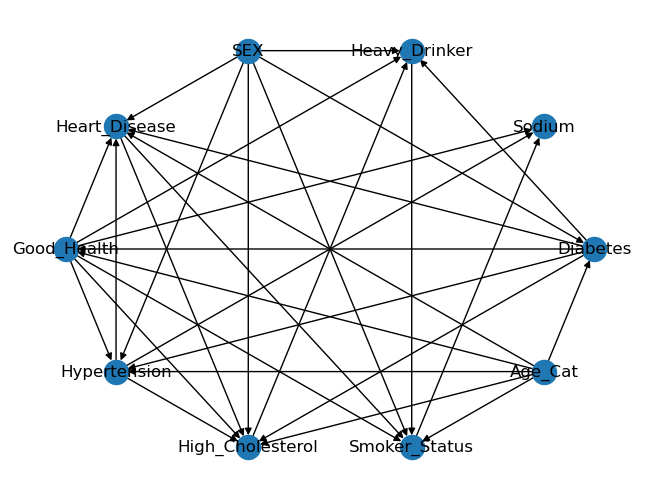

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw_shell(inference_model, with_labels=True)
plt.show()

In [15]:
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(inference_model)

In [33]:
dict_parents = {}
for parent in inference_model.get_parents('Heart_Disease'):
    dict_parents[parent]= list(X[parent].unique())
dict_parents

{'Good_Health': ['2', '1', '9'],
 'Hypertension': ['1', '2', '9'],
 'Age_Cat': ['5', '4', '6', '3', '2', '1'],
 'Diabetes': ['2', '1', '7', '999', '9'],
 'SEX': ['2', '1']}

In [30]:
def discrete_factor_to_series(factor, name=None):
    variables = factor.scope()
    n_states = 1
    for cardinality in factor.get_cardinality(variables).values():
        n_states = n_states * cardinality
    state_indices = list(range(n_states))
    assignments = factor.assignment(state_indices)
    state_names = []
    for assignment in assignments:
        state_name = ''
        for tuple_ in assignment:
            state_name = state_name +  '__' + tuple_[0] + '_' + tuple_[1]
        state_names.append(state_name)
    states_dicts = [{state[0]:state[1] for state in assignment} for assignment in assignments]
    values = [round(factor.get_value(**dict_), 4) for dict_ in states_dicts]

    return pd.Series(values, index=state_names, name=name)

In [34]:
phi_dict = {}
queried_features = ['Heart_Disease']
phi_dict['No intervention'] = inference.query(queried_features)
for parent, values in dict_parents.items():
    for value in values:
        name = f'{parent}_{value}'
        phi_dict[name] = inference.query(queried_features, do={parent:value})
phi_dict['Hypertension_2.0, High_Cholesterol_2.0'] = inference.query(queried_features, do={'Hypertension':'2', 'Diabetes':'2'})

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [35]:
series_list = []
for name, factor in phi_dict.items():
    series_list.append(discrete_factor_to_series(factor, name))

infer_df = pd.DataFrame()
columns = []
for series in series_list:
    columns.append(series.name)
    infer_df = pd.concat([infer_df, series], axis=1)
infer_df.columns = columns
infer_df = infer_df.T

In [36]:
infer_df

,__Heart_Disease_0,__Heart_Disease_1
No intervention,0.9104,0.0896
Good_Health_2,0.8106,0.1894
Good_Health_1,0.9375,0.0625
Good_Health_9,0.8647,0.1353
Hypertension_1,0.8837,0.1163
Hypertension_2,0.9397,0.0603
Hypertension_9,0.9040,0.0960
Age_Cat_5,0.9136,0.0864
Age_Cat_4,0.9531,0.0469
Age_Cat_6,0.8283,0.1717


In [37]:
for index in infer_df.index:
    print(infer_df.loc[index, :].sum())

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


**Testing Active Trail Function**

In [ ]:
toy_model = BayesianNetwork([('Difficulty', 'Grade'), ('Intelligence', 'Grade'),('Intelligence', 'SAT'), ('Grade', 'Letter')])

In [ ]:
toy_model.get_random_cpds(n_states = {'Difficulty':2, 'Intelligence':2, 'Grade':5, 'SAT':2, 'Letter':2}, inplace=True)

In [ ]:
help(BayesianNetwork)

In [ ]:
nx.draw_kamada_kawai(toy_model, with_labels=True)

In [ ]:
for node in toy_model.nodes:
    print(toy_model.active_trail_nodes(node, []))

In [ ]:
toy_model.nodes

In [ ]:
toy_model.states

In [ ]:
df_toy = pd.DataFrame(index=[0])

In [ ]:
df_toy

In [ ]:
toy_model.predict_probability(df_toy)

In [ ]:
toy_model.active_trail_nodes(['SAT'])